In [43]:
%pip install --upgrade pip
%pip install torch
%pip install cmake
%pip install swig
%pip install 'pettingzoo[all]'
%pip install matplotlib

8202.77s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.
8209.24s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.
8215.33s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.
8221.34s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.
8227.38s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.
8233.70s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from pettingzoo.mpe import simple_spread_v3

class DeepQNetwork(nn.Module):
    # 멤버 객체 설정 및 저장
    def __init__(self, lr, state_dims, fc1_dims, fc2_dims, n_actions):
        super(DeepQNetwork, self).__init__()
        self.state_dims = state_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*state_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.fc3 = nn.Linear(fc2_dims, n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
    # state를 받아서 각 action에 대한 예상 Q-value를 벡터로 반환 : Q(s)[a]
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        Q_vals_for_each_actions = self.fc3(x)
        return Q_vals_for_each_actions


class DeepQLearningAgent:
    # 멤버 객체 설정 및 저장
    def __init__(self, state_dims=(4,), n_actions=2, gamma=0.99, epsilon=1.0, lr=0.003, batch_size=64, 
                 mem_size=100000, eps_min=0.01, eps_dec=0.0):
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.state_dims = state_dims
        self.batch_size = batch_size
        self.mem_size = mem_size
        self.eps_min = eps_min
        self.eps_dec = eps_dec

        self.action_space = [i for i in range(n_actions)]
        self.mem_cntr = 0

        self.Q_eval = DeepQNetwork(self.lr, n_actions=n_actions, 
                                   state_dims=state_dims, fc1_dims=16, fc2_dims=16)
        self.state_memory = np.zeros((self.mem_size, *state_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.next_state_memory = np.zeros((self.mem_size, *state_dims), dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool_)
    # s, a, r, s'을 history로 기록
    def store_transition(self, state, action, reward, next_state, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.next_state_memory[index] = next_state
        self.terminal_memory[index] = done
        self.mem_cntr += 1
    # s를 받아서 DeepQNetwork으로부터 얻은 Q(s)[a]에 따라 greedy action 선택
    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space).item()
        else:
            state = torch.Tensor(state, device=self.Q_eval.device)
            Q_vals_for_each_actions = self.Q_eval.forward(state)
            action = torch.argmax(Q_vals_for_each_actions).item()
        return action
    # learn를 main에서 반복 호출하면 학습이 진행됨
    def learn(self):
        if self.mem_cntr < self.batch_size:
            return
        self.Q_eval.optimizer.zero_grad()
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, size=self.batch_size, replace=False)
        batch_index = torch.arange(self.batch_size, dtype=torch.int32)
        # batch = []
        state_batch = torch.Tensor(self.state_memory[batch], device=self.Q_eval.device).float()
        action_batch = torch.Tensor(self.action_memory[batch], device=self.Q_eval.device).int()
        reward_batch = torch.Tensor(self.reward_memory[batch], device=self.Q_eval.device).float()
        next_state_batch = torch.Tensor(self.next_state_memory[batch], device=self.Q_eval.device).float()
        terminal_batch = torch.Tensor(self.terminal_memory[batch], device=self.Q_eval.device).bool()
        # print(*map(lambda x : x.size(), [state_batch, action_batch, reward_batch, next_state_batch, terminal_batch]))

        # state_batch의 크기: batch_size * state_dim
        # self.Q_eval.forward(state_batch)의 크기: batch_size * n_action
        # action_batch의 크기: batch_size * 1 (0 ~ n_action-1)
        # q의 크기: batch_size * 1
        # 0 1 2 3 / 1 0 0 1
        # [Q(s1)[a1], Q(s2)[a2], ..., Q(sn)[an]] (n=batch_size)
        # q_next=self.Q_eval.forward(next_state_batch)의 크기: batch_size * n_action
        # terminal_batch: [False, False, True, False]
        # torch.max(q_next, dim=1)의 크기: batch_size * n_action
        
        q = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(next_state_batch)
        q_next[terminal_batch, :] = 0.0
        max_q = torch.max(q_next, dim=1)
        q_target = reward_batch + self.gamma * max_q[0]
        loss = self.Q_eval.loss(q_target, q).to(self.Q_eval.device)
        # print(q.size(), q_next.size(), q_target.size(), max_q, loss.size())
        loss.backward()
        self.Q_eval.optimizer.step()
        if self.eps_dec != 0.0:
            self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min
        else:
            self.epsilon = 1000 / (1000 + self.mem_cntr)


def batchify_obs(obs, device):
    """Converts PZ style observations to batch of torch arrays."""
    # convert to list of np arrays
    obs = np.stack([obs[a] for a in obs], axis=0)
    # transpose to be (batch, channel, height, width)
    obs = obs.transpose(0, -1, 1, 2)
    # convert to torch
    obs = torch.tensor(obs).to(device)

    return obs


def batchify(x, device):
    """Converts PZ style returns to batch of torch arrays."""
    # convert to list of np arrays
    x = np.stack([x[a] for a in x], axis=0)
    # convert to torch
    x = torch.tensor(x).to(device)

    return x


def unbatchify(x, env):
    """Converts np array to PZ style arguments."""
    x = x.cpu().numpy()
    x = {a: x[i] for i, a in enumerate(env.possible_agents)}

    return x


if __name__ == '__main__':
    # OpenAI gym 환경 생성
    env = simple_spread_v3.parallel_env(render_mode="human")
    env.reset()
    n_agents = env.num_agents
    n_actions = env.action_space(env.possible_agents[0]).n
    state_dims = env.observation_space(env.possible_agents[0]).shape

    # 앞서 정의한 DeepQLearingAgent 클래스의 객체를 딕셔너리 생성
    agent_instances = {agent:DeepQLearningAgent(state_dims=state_dims, n_actions=n_actions, gamma=0.99, epsilon=1.0, 
                                                lr=0.003, batch_size=32, eps_min=0.01) for agent in env.agents}
    # 변수 선언
    score_history, eps_history, avg_score_history = [], [], []
    n_episodes = 100
    
    # 게임을 여러 차례 돌린다
    for episode in range(n_episodes):
        # 변수 선언
        obs, infos = env.reset()
        scores = {agent:0 for agent in env.agents}
        dones = {agent:False for agent in env.agents}
        epsilons = {agent:agent_instances[agent].epsilon for agent in env.agents}
        # 게임 종료 전까지 s, a, r, s' 생성, 학습 및 기록
        while env.agents:
            actions = {agent:agent_instances[agent].choose_action(obs[agent]) for agent in env.agents}
            next_obs, rewards, terminations, truncations, _ = env.step(actions)
            for agent in env.agents:
                scores[agent] += rewards[agent]
                agent_instances[agent].store_transition(obs[agent], actions[agent], rewards[agent], next_obs[agent], dones[agent])
                agent_instances[agent].learn()
            obs = next_obs
        # 최종 점수 및 epsilon 기록, 평균 점수 기록
        score_history.append(scores)
        eps_history.append(epsilons)
        # avg_scores = {agent:np.mean(score_history[-100:][agent]) for agent in env.agents}
        # avg_score_history.append(avg_scores)
        # 중요 정보 출력
        print('episode ', episode, 'scores', scores, 'epsilons', epsilons)

episode  0 scores {'agent_0': -27.49339274886607, 'agent_1': -27.49339274886607, 'agent_2': -27.49339274886607} epsilons {'agent_0': 1.0, 'agent_1': 1.0, 'agent_2': 1.0}
episode  1 scores {'agent_0': -25.425594800530845, 'agent_1': -25.425594800530845, 'agent_2': -23.925594800530845} epsilons {'agent_0': 1.0, 'agent_1': 1.0, 'agent_2': 1.0}
episode  2 scores {'agent_0': -22.372440597860884, 'agent_1': -23.872440597860884, 'agent_2': -22.372440597860884} epsilons {'agent_0': 0.9541984732824428, 'agent_1': 0.9541984732824428, 'agent_2': 0.9541984732824428}
episode  3 scores {'agent_0': -20.86897464142266, 'agent_1': -20.86897464142266, 'agent_2': -20.86897464142266} epsilons {'agent_0': 0.9328358208955224, 'agent_1': 0.9328358208955224, 'agent_2': 0.9328358208955224}
episode  4 scores {'agent_0': -16.601069737353473, 'agent_1': -16.601069737353473, 'agent_2': -15.101069737353473} epsilons {'agent_0': 0.9124087591240876, 'agent_1': 0.9124087591240876, 'agent_2': 0.9124087591240876}
episod

In [3]:
import matplotlib.pyplot as plt

# Learning curve 그리기
def plot_learning_curve(score_history, eps_history, filename, lines=None):
    fig=plt.figure()
    ax1=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    x = [i+1 for i in range(len(score_history))]
    y1 = [score_history[i]['agent_0'] for i in range(len(score_history))]
    y2 = [eps_history[i]['agent_0'] for i in range(len(eps_history))]
    ax1.plot(x, y1, color="pink")
    ax2.plot(x, y2, color="blue")
    
    ax1.set_xlabel("# episodes", color="black")
    ax1.set_ylabel("Epsilons / scores", color="black")
    ax1.tick_params(axis='x', colors="black")
    ax1.tick_params(axis='y', colors="black")

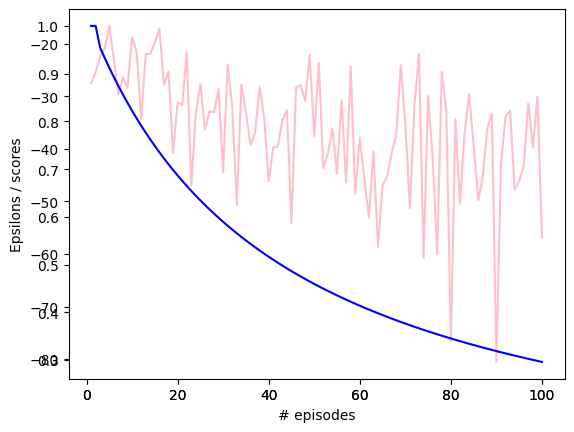

In [4]:
plot_learning_curve(score_history, eps_history, "Multi-agent-Deep-Q-Learning.png")